# SHAPxTitanic

## 01 Load, inspect and clean data

SHapley Additive exPlanations (or SHAP for short) can be used to explain individually predictions made by ML models by calculating the contribution of each feature to each prediction. It is particularly useful to use in combination with methods that are not normally known for their interpretability. The fact that each prediction is analysed individually is also intriguing. I can see how this could be useful when tailoring a response at an individual level.

I've been interested in learning more about SHAP for a while, so thought I'd have a play around with it on the titanic dataset.

**Acknowledgements/Helpful sources** 

After doing some Googling, I found that Manuel Amunategui from Viral ML had a video detailing how to apply SHAP to the titanic dataset, and had shared his source code (https://www.viralml.com/video-content.html?v=ZkIxZ5xlMuI). He used a model I'd not heard of before called Catboost which I'm going to look more into and use here too! I've watched a few of his videos since discovering him, and highly recommend his content :)

In [153]:
# install packages
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from plotnine import *
from plotnine.data import mpg
%matplotlib inline

import re
from sklearn.model_selection import train_test_split

import shap



## 1. Load and inspect data

In [154]:
# Downloaded the titanic dataset from the Kaggle competition
titanic_df = pd.read_csv('train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [155]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [156]:
titanic_df.shape

(891, 12)

In [157]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [158]:
print(titanic_df.apply(lambda col: col.unique()))

PassengerId    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Survived                                                  [0, 1]
Pclass                                                 [3, 1, 2]
Name           [Braund, Mr. Owen Harris, Cumings, Mrs. John B...
Sex                                               [male, female]
Age            [22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,...
SibSp                                      [1, 0, 3, 4, 2, 5, 8]
Parch                                      [0, 1, 2, 5, 3, 4, 6]
Ticket         [A/5 21171, PC 17599, STON/O2. 3101282, 113803...
Fare           [7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51....
Cabin          [nan, C85, C123, E46, G6, C103, D56, A6, C23 C...
Embarked                                          [S, C, Q, nan]
dtype: object


In [159]:
# 20% age missing, 77% cabin is missing, 0.2% embarked missing
(titanic_df.isnull().sum()/len(titanic_df))*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [160]:
# PassengerId - id unique to passenger, 
# Survived - binary response, this is a classification problem, currently a number, needs to be a dummy
# Pclass - numeric but relates to class of passenger so need to convert to cat var. Higher class, higher survival I assume
# Name - char. Could be useful in identifying married women?
# Sex - char but convert to dummy
# Age - missing some variables, continuous. min age a decimal? Kids likely to have higher survival.
# SibSp - number of siblings/spouse on board. 
# Parch - number of parents/children on board. Perhaps those with bigger families were less likely to survive? More kids to locate on the boat.
# Ticket - ticket number
# Fare - ticket price in £
# Cabin - cabin number, contains nans
# Embarked - where the passenger embarked, (C = Cherbourg; Q = Queenstown; S = Southampton), contains nans

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

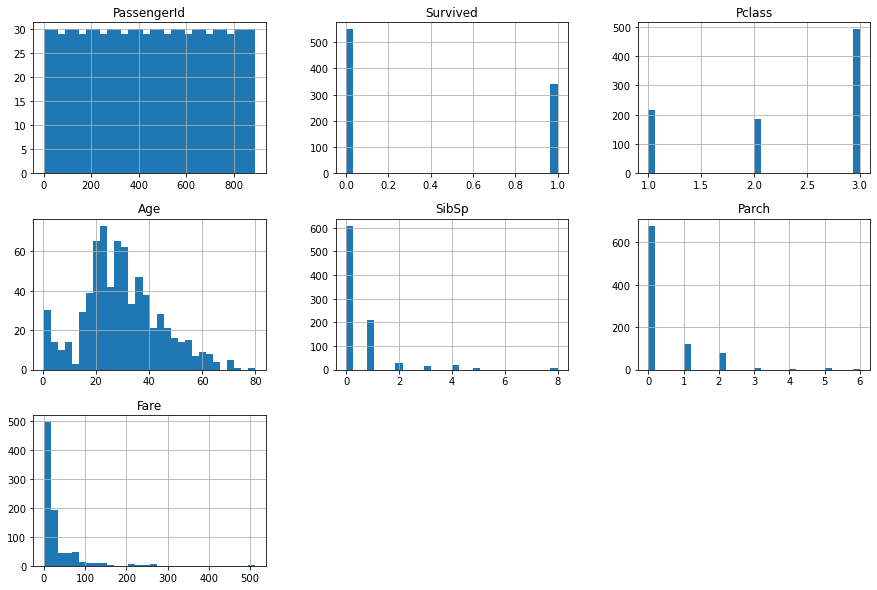

In [161]:
titanic_df.hist(bins=30, figsize=(15, 10))
# Survived response - we have more who died than survived, but doesn't look like a major class imbalance problem
# Appear to be some outliers for Fare at the high end

## 3. Clean and explore data

In [162]:
# create female field and use numerical values, 1 = female, 0 = male
titanic_df['Female'] = np.where(titanic_df['Sex'] == 'female', 1, 0)

# make pclass categorical
titanic_df['Pclass'] = np.where(titanic_df['Pclass'] == 1, 'First', 
                                np.where(titanic_df['Pclass'] == 2, 'Second', 'Third'))

# make survived categorical
titanic_df['Survived'] = titanic_df['Survived'].astype('category')

# replace with unknown or use most common?
titanic_df['Embarked'] = titanic_df['Embarked'].replace(np.NaN, 'Unknown') 

# 

titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female
0,1,0,Third,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,First,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,Third,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,First,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,Third,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### 3.1 Dealing with missing values
From above we know that the majority of the cabin var is missing, 1/5 of age and few embarked obs.

In [163]:
# Replace embarked with most common value

print(titanic_df['Embarked'].value_counts())

print(titanic_df['Embarked'].isnull().sum())
# one two values are missing, so safe enough to assume they can take the mode or be removed
# i'd prefer to leave in and take mode

titanic_df['Embarked'] = titanic_df['Embarked'].replace(np.NaN, 'S') 

S          644
C          168
Q           77
Unknown      2
Name: Embarked, dtype: int64
0


248


geom_point : Removed 177 rows containing missing values.


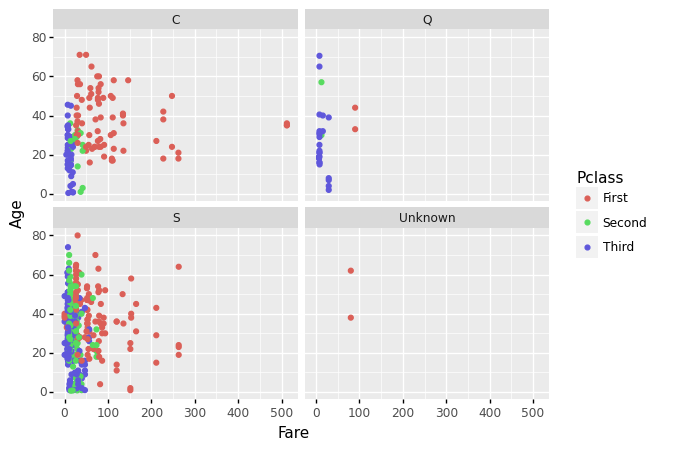

<ggplot: (126225782821)>

In [164]:
# Compute age with mean? I think we can do better. Using the title of a passenger, we can infer whether they are a child or not.
# We could also look at the fare price, I presume those who are younger, typically pay less than those older

print(titanic_df['Fare'].nunique())

(ggplot(titanic_df)
+ aes(x='Fare', y='Age',color='Pclass')
    + geom_point()
    + facet_wrap('Embarked'))


In [165]:
# Looking at the plot above, there doesn't appear to be a clear relationship between fare and age, so using it to compute missing values for age maybe isn't the way to go.
# Instead I'll go with the titles of the passengers, take the mean of age and use that to compute the missing values.
# This is not ideal for those with 'Miss' who are not married. So I will combine with Parch too.
# This will follow the assumption that those called 'Miss' who are with parents/siblings are children. 
# They might be onboard with a parent/sibling, not be married and may be adults, but its a fairer assumption than classing all those with 'Miss' as children.
# I'll address the outliers in the plot later on.

titanic_df['Name'].head(10)

# Looks like the title of each passenger is stored within the name
# Lastname, Title. Othernames

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [166]:
string = 'Nasser, Mrs. Nicholas (Adele Achem)'
pattern = '\s' # matches whitespace characters

print(re.split(pattern, string))
re.split(pattern, string)[1]

['Nasser,', 'Mrs.', 'Nicholas', '(Adele', 'Achem)']


'Mrs.'

In [167]:
titanic_df['Title'] =  [re.split('\s', str(x))[1] for x in titanic_df['Name']]
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Title
0,1,0,Third,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr.
1,2,1,First,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs.
2,3,1,Third,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss.
3,4,1,First,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs.
4,5,0,Third,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr.


In [168]:
titanic_df['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Planke,', 'Don.', 'Rev.',
       'Billiard,', 'der', 'Walle,', 'Dr.', 'Pelsmaeker,', 'Mulder,', 'y',
       'Steen,', 'Carlo,', 'Mme.', 'Impe,', 'Ms.', 'Major.', 'Gordon,',
       'Messemaeker,', 'Mlle.', 'Col.', 'Capt.', 'Velde,', 'the',
       'Shawah,', 'Jonkheer.', 'Melkebeke,', 'Cruyssen,'], dtype=object)

In [169]:
# So that didn't work on all names, let's have a look at one
titanic_df[titanic_df['Title'].str.contains("Melkebeke")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Title
868,869,0,Third,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5,NaN,S,0,"Melkebeke,"


In [170]:
# Last names with spaces! An alternative way of retrieving title looks to be..
# comma space Title fullstop

string1 = 'van Melkebeke, Mr. Philemon'
pattern1 = '(?<=\,)(.*?)(?=\.)' 

re.split(pattern1, string1)

['van Melkebeke,', ' Mr', '. Philemon']

In [171]:
titanic_df['Title'] = [re.split('(?<=\,)(.*?)(?=\.)', str(x))[1] for x in titanic_df['Name']]
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Female,Title
0,1,0,Third,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr
1,2,1,First,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs
2,3,1,Third,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Miss
3,4,1,First,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs
4,5,0,Third,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr


In [172]:
titanic_df['Title'].unique() # Much better

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

In [173]:
titanic_df[titanic_df['Age'].isnull()]['Title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Dr'], dtype=object)

In [174]:
# Takes in data frame
# Saves list of titles with missing ages
# Gets passengers title
# Find mean in data frame for that title

In [175]:
avg_age_by_title = pd.DataFrame(titanic_df[['Title','Age']].groupby(['Title']).mean())
avg_age_by_title = avg_age_by_title.rename(columns={"Age": "imputed_age"})

titanic_df = titanic_df.merge(avg_age_by_title, how='left', on='Title')
titanic_df['Age'] = np.where(titanic_df['Age'].isnull(), titanic_df['imputed_age'], titanic_df['Age'])

<AxesSubplot:>

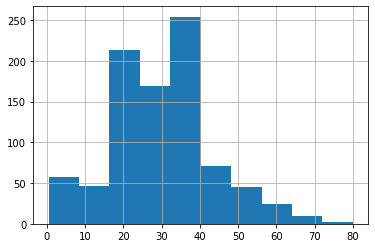

In [176]:
titanic_df['Age'].hist()

In [177]:
# Remove Cabin for now - too many nulls, and unsure of its importance 
titanic_df = titanic_df.drop(['Cabin'], axis=1)

In [178]:
# Quickly look at outliers here and remove vars/change if req

## 1.3 Access the relationship between vars and the survival response

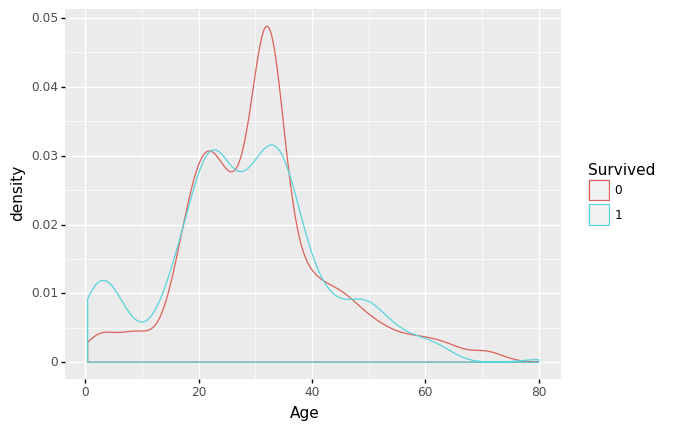

<ggplot: (126225961801)>

In [180]:
# Those ten and under were more likely to survive, the red peak is likely to be men, but can check
(ggplot(titanic_df) +
aes(x='Age', color='Survived') + geom_density()) 

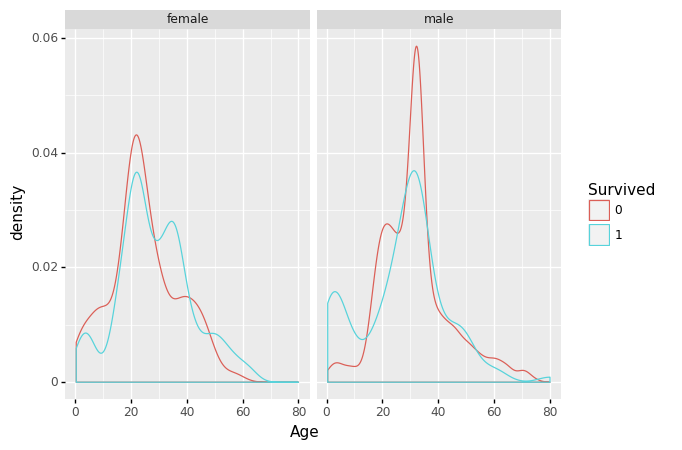

<ggplot: (126226297085)>

In [181]:
(ggplot(titanic_df) +
aes(x='Age', color='Survived') + geom_density() + facet_wrap('Sex')) 
# Yep lots of males between 30-40 died - prioritising their families presumably
# Not how young males are more likely to survive but its less clear for females - this could be partly due to the imputation

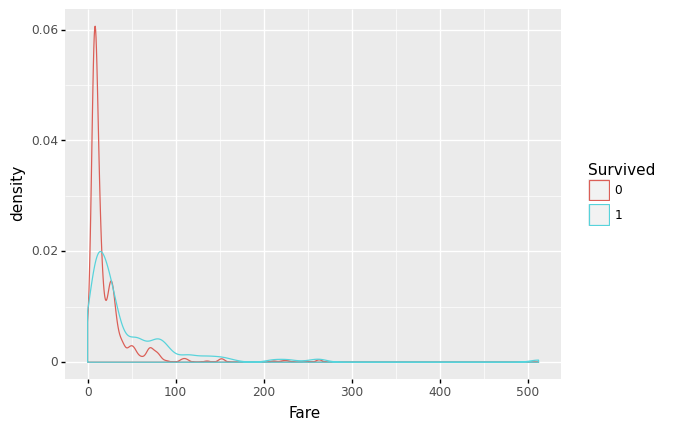

<ggplot: (126226032077)>

In [182]:
# There is a relationship here - those who had a very low fare (probably a result of class) were less likely to survive
(ggplot(titanic_df) +
aes(x='Fare', color='Survived') + geom_density()) 

In [183]:
# Next, run some t tests to compare how close categorical variables are to the response
# Then, play with some modelling and see if shap shows what we have seen above!